In [77]:
from sklearn import tree
import numpy as np
import pandas as pd
df=pd.read_excel(r"C:\Users\rcm1\Documents\PATTERN_ANALYSIS\nodes_out_extended_tree.xlsx")
IV=pd.read_excel(r"C:\Users\rcm1\Documents\PATTERN_ANALYSIS\infovalue_extended.xlsx")
df=df.iloc[:,1:103]
listc=df.columns
df.head()

,Row Labels,Target,202110_int,202111_int,202112_int,Q1_int,Q2_int,Q3_int,Q4_int,half_yearly_1_int,...,202110_Repeat,202111_Repeat,202112_Repeat,Q1_Repeat,Q2_Repeat,Q3_Repeat,Q4_Repeat,half_yearly_1_Repeat,half_yearly_2_Repeat,Yearly_Repeat
0,N1013A,0,7,12,1,13,15,15,13,9,...,5,7,0,5,17,1,8,18,1,1
1,N1093A,0,9,11,1,13,17,18,13,9,...,3,1,0,18,3,1,5,5,1,1
2,N1181A,0,7,10,5,15,13,15,4,9,...,3,6,0,8,3,1,8,15,1,1
3,N1229A,0,10,7,1,13,14,18,9,9,...,6,17,0,8,3,1,16,15,1,1
4,N1321A,0,10,10,1,16,14,18,4,10,...,6,1,0,5,3,1,8,17,1,1


In [78]:
IV.shape

(99, 3)

# To manually set Variables according to IV values : 
Information Value	Predictive Power

< 0.02	useless for prediction

0.02 to 0.1	Weak predictor

0.1 to 0.3	Medium predictor

0.3 to 0.5	Strong predictor

 >0.5	Suspicious or too good to be true

In [95]:
# Picking up Strong : 
new_value=[]
for i,j in IV.iterrows():
    if j['IV_value']<= 0.60 and j['IV_value'] > 0.30:
        new_value.append(j)
IV=pd.DataFrame(new_value)
IV =IV.sort_values(ascending=False,by=['IV_value'])

In [80]:
# IV.to_excel('IV_VALUE_New.xlsx')

In [81]:
print(len(IV))
IV.head()

39


,Unnamed: 0,name,IV_value
42,78,half_yearly_2_DAMAGE,0.792119
43,26,Q4_MESSAGE,0.753521
44,69,Yearly_FAIL,0.752892
45,10,202110_Pirep,0.744887
46,27,half_yearly_1_MESSAGE,0.726809


In [82]:
import warnings
warnings.filterwarnings('ignore')

In [83]:
# Assigning the WOE to the variables choosen on the basis of the IV values for further analysis
# Will select those variables fitting in IV values range given in above code.
Y=df.iloc[:,1:2]
totalIVlist=[]
colname=[]

woe_table=pd.DataFrame()
for l in range(2,101):
    X=df.iloc[:,l:l+1]
    df_=pd.merge(Y,X,left_index=True,right_index=True)
    list1=[]
    count0list=[]
    count1list=[]
    for i,j in df_.iterrows():
        count0=0
        count1=0
        a=j[listc[l]]
        if j[listc[l]] in list1:
            pass
        else:
            list1.append(a)
            for b,z in df_.iterrows():
                if a==z[listc[l]]:
                    if z['Target']==0:
                        count0=count0+1
                    else:
                        count1=count1+1
            count0list.append(count0)
            count1list.append(count1)
    pivot=pd.DataFrame({'nodes':list1,'0':count0list,'1':count1list})
    pivot=pivot.sort_values(by=['nodes'])
    pivot['Grand Total']=pivot['0']+pivot['1']
    pivot['percent_G']=pivot['0']/pivot['Grand Total']
    pivot['% of Good']=pivot['0']/86
    pivot['percent_B']=pivot['1']/pivot['Grand Total']
    pivot['% of Bad']=pivot['1']/21
    pivot['%G-%B']=pivot['% of Bad']-pivot['% of Good']
    pivot['WOE']=np.log(pivot['% of Bad']/pivot['% of Good'])
    pivot['IV']=pivot['WOE']*pivot['%G-%B']
    pivot.replace([np.inf, -np.inf], np.nan, inplace=True)
    woe=[]
    woe_list=[]
    for index,f in IV.iterrows():
        if f['name']==listc[l]:
            for index_,g in df.iterrows():
                for index__,h in pivot.iterrows():
                    if h['nodes']==g[listc[l]]:
                        woe.append(h['WOE'])
            woe_table[listc[l]]=woe
    totalIV=pivot['IV'].sum()
    totalIVlist.append(totalIV)
    colname.append(listc[l])
woe_table.to_excel('D:\woe_ooutput.xlsx')
table=pd.DataFrame({'name':colname,'IV':totalIVlist})
#table

In [84]:
#iv_sort=table.sort_values(ascending=False,by=['IV'])
#iv_sort=iv_sort.iloc[0:30,:]
#iv_sort.head()

In [85]:
# table.to_excel(r'D:\infovalue_descisiontree.xlsx')

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

In [87]:
Best_var = woe_table.copy()

In [88]:
Best_var = Best_var.fillna(0)


# Splitting the variables 

In [89]:
# X = Best_var
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Best_var,Y,test_size=0.17,random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(88, 39) (19, 39) (88, 1) (19, 1)


# 1) LOGISTIC REGRESSION 

# Fitting the model

In [90]:
# solver = 'liblinear', class_weight="balanced"
log_regression = LogisticRegression(solver='liblinear', class_weight= 'balanced')
log_regression.fit(X_train,y_train) # Fitting the Training Set 

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score,roc_curve
plt.style.use('fivethirtyeight')
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

In [92]:
# train_pred = log_regression.predict(X_train)
y_pred = log_regression.predict(X_test) # Predicted Varibale

In [93]:
# OUTPUT PROBABILITY
#train_prob = log_regression.predict_proba(X_train)
y_pre_proba = log_regression.predict_proba(X_test)
print(y_pre_proba)

[[0.80593693 0.19406307]
 [0.22433032 0.77566968]
 [0.82356407 0.17643593]
 [0.99880322 0.00119678]
 [0.92596562 0.07403438]
 [0.72137069 0.27862931]
 [0.99592324 0.00407676]
 [0.25413204 0.74586796]
 [0.98567197 0.01432803]
 [0.97654476 0.02345524]
 [0.32221495 0.67778505]
 [0.76734034 0.23265966]
 [0.60121169 0.39878831]
 [0.02572375 0.97427625]
 [0.24453501 0.75546499]
 [0.26421722 0.73578278]
 [0.98924046 0.01075954]
 [0.99385379 0.00614621]
 [0.99156696 0.00843304]]


In [94]:
# CHecking accuracy for LG_reg model 
acc = accuracy_score(y_test, y_pred)
print('Accuracy is:', acc)

Accuracy is: 0.7368421052631579


In [206]:
#report = classification_report(y_test, y_pred, output_dict=True)
#pd.DataFrame(report).transpose()

Accuracy = (True Positive + True Negative) / (True Positive + False Positive + True Negative + False Negative).

The precision for class 1 is, out of all predicted class values like 1, how many actually belong to class 1. Precision = TP / (TP + FP).

Recall for class 1 is, out of all the values that actually belong to class 1, how much is predicted as class 1. Recall = TP / (TP + FN).


In [313]:
conf = confusion_matrix(y_test, y_pred) 
print('Confusion Matrix is  :\n',conf)
TPl = conf[0][0]
FPl = conf[0][1]
FNl = conf[1][0]
TNl = conf[1][1]
print ('TP is :', TPl) 
print('FP is :', FPl) 
print('FN is :', FNl)
print('TN is :', TNl)

Confusion Matrix is  :
 [[12  2]
 [ 1  4]]
TP is : 12
FP is : 2
FN is : 1
TN is : 4


# Predicting Probability for full model : 

In [285]:
model_LR = log_regression.fit(Best_var,Y)

In [286]:
y_LR_pred = model_LR.predict(Best_var)
y_LR_proba = model_LR.predict_proba(Best_var)

In [288]:
np.set_printoptions(suppress = True) # This will suppress the expoential probability output. 
pd.DataFrame(y_LR_pred).to_excel('LR_whole_pred.xlsx')

In [155]:
#report1 = classification_report(y_test, y_pred1, output_dict=True)
#Cl_report1 = pd.DataFrame(report1).transpose()

# Upon applying the LR 
The accuracy has dipped significantly after changin' setting the Range for IV value (0.5>IV>0.3).

Previously it was 94 % now after filtering IV value its 73.68 %

# ROC Curve for LG Regression (Lib_Linear)

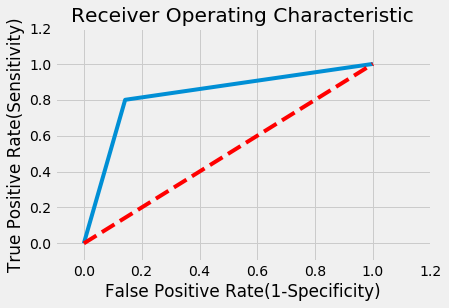

In [300]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate(Sensitivity)')
plt.xlabel('False Positive Rate(1-Specificity)')
plt.show()

# 2) SVM CLASSIFIER

In [305]:
from sklearn import svm 
mod_svm = svm.SVC(kernel='linear', probability= True)
svcc = mod_svm.fit(X_train,y_train)
y_svc_pred = svcc.predict(X_test)
y_svc_proba = svcc.predict_proba(X_test)

In [245]:
pd.DataFrame(y_svc_pred).to_excel('SVC_test_prediction_03Mar.xlsx')
pd.DataFrame(y_svc_proba).to_excel('SVC_test_proba_03Mar.xlsx')

In [208]:
# Best_var.head()

In [214]:
# Preciting Probablities for full data 
sv1 = mod_svm.fit(Best_var,Y)
y_train_pred = sv1.predict(Best_var)
y_train_proba = sv1.predict_proba(Best_var)

In [262]:
y_train_proba

array([[0.87495804, 0.12504196],
       [0.98264336, 0.01735664],
       [0.76732338, 0.23267662],
       [0.95364839, 0.04635161],
       [0.98399115, 0.01600885],
       [0.91514538, 0.08485462],
       [0.9326792 , 0.0673208 ],
       [0.76738271, 0.23261729],
       [0.86142135, 0.13857865],
       [0.4633196 , 0.5366804 ],
       [0.94578484, 0.05421516],
       [0.94954171, 0.05045829],
       [0.85429749, 0.14570251],
       [0.97099116, 0.02900884],
       [0.81426053, 0.18573947],
       [0.87171576, 0.12828424],
       [0.96130562, 0.03869438],
       [0.97465775, 0.02534225],
       [0.46552523, 0.53447477],
       [0.97764477, 0.02235523],
       [0.97957013, 0.02042987],
       [0.96478643, 0.03521357],
       [0.76740257, 0.23259743],
       [0.84672172, 0.15327828],
       [0.88711563, 0.11288437],
       [0.6483394 , 0.3516606 ],
       [0.66451567, 0.33548433],
       [0.46552559, 0.53447441],
       [0.4654912 , 0.5345088 ],
       [0.89696835, 0.10303165],
       [0.

In [250]:
pd.DataFrame(y_train_pred).to_excel('SVC_whole_pred.xlsx')

In [210]:
#accuracy_score(y_train_pred,Y)

In [215]:
y_full_pred = y_train_pred.reshape(-1,1)
y_full_pred = pd.DataFrame(y_train_pred)
y_full_proba = pd.DataFrame(y_train_proba)
out_proba11 = pd.merge(y_full_proba,y_full_pred, left_index=True, right_index=True)

In [246]:
out_proba11.to_excel('SVC_training_set_proba.xlsx')

In [306]:
# SVM Accuracy score 
acc_svc = accuracy_score( y_svc_pred,y_test)
print('The accuracy is :, ' acc_svc*100)

73.68421052631578

In [235]:
y_svc_proba.shape

(19, 2)

In [51]:
# out_proba11.to_excel('Out_with_proba_full_data.xlsx')

In [168]:
# Taking Output to Excel
#y_svc = y_svc_pred.reshape(-1,1)
#y_svc = pd.DataFrame(y_svc)
#y_svc_proba = pd.DataFrame(y_svc_proba)
#out_proba = pd.merge(y_svc_proba,y_svc, left_index=True, right_index=True)
#out_proba.head()
#TEST_y = y_test.reset_index()
#TEST_y.to_excel('Test_y_values.xlsx')
#out_proba.to_excel('Out_with_probability.xlsx')


In [312]:
# Confusion MATRIX SVM  :
conf_sv=  confusion_matrix(y_svc_pred, y_test) 

TPS = conf_sv[0][0]
FPS = conf_sv[0][1]
FNS = conf_sv[1][0]
TNS = conf_sv[1][1]
print(conf_sv)
print ('TP is :', TPS) 
print('FP is :', FPS) 
print('FN is :', FNS)
print('TN is :', TNS)


[[13  4]
 [ 1  1]]
TP is : 13
FP is : 4
FN is : 1
TN is : 1


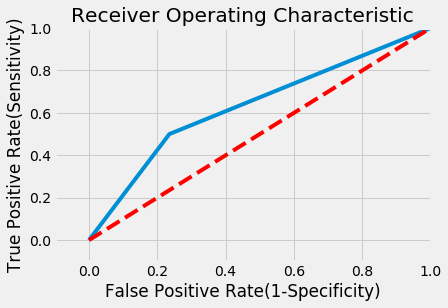

In [310]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_svc_pred, y_test)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate(Sensitivity)')
plt.xlabel('False Positive Rate(1-Specificity)')
plt.show()

# 3) NAIVE BAYESIAN CLASSIFIER

1) BERNOULLI NB

In [289]:
from sklearn.naive_bayes import BernoulliNB
clas_BNB= BernoulliNB()
clas_BNB.fit(X_train, y_train)
y_pred_NB = clas_BNB.predict(X_test)

In [292]:
# printing the accuracy of the model
print(accuracy_score(y_pred_NB, y_test))

0.8421052631578947


In [315]:
conf_NB =  confusion_matrix(y_test, y_pred_NB) 

TP = conf_NB[0][0]
FP = conf_NB[0][1]
FN = conf_NB[1][0]
TN = conf_NB[1][1]
print(conf_NB)
print ('TP is :', TP) 
print('FP is :', FP) 
print('FN is :', FN)
print('TN is :', TN)

[[11  3]
 [ 0  5]]
TP is : 11
FP is : 3
FN is : 0
TN is : 5


In [323]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

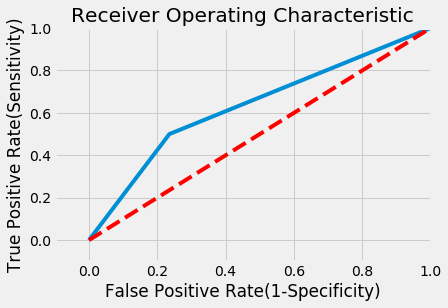

In [325]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_svc_pred, y_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate(Sensitivity)')
plt.xlabel('False Positive Rate(1-Specificity)')
plt.show()

In [316]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [318]:
print(TPR)
print(TNR)
print(PPV)
print(NPV)
print(FPR)
print(FNR)
print(FDR)

1.0
0.625
0.7857142857142857
1.0
0.375
0.0
0.21428571428571427


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


# FULL DATA PROBA USING BNB

In [290]:
bnb = clas_BNB.fit(Best_var, Y)
fu_pred = bnb.predict(Best_var)
fu_prob = bnb.predict_proba(Best_var)

In [297]:
pd.DataFrame(fu_prob).to_excel('BNB_whole_proba.xlsx')

In [175]:
# WOE(WEIGHT OF EVIDENCE AND INFORMATION VALUEE)

In [4]:
list1=[]
count0list=[]
count1list=[]
for i,j in df_.iterrows():
    count0=0
    count1=0
    a=j['202110_int']
    if j['202110_int'] in list1:
        pass
    else:
        list1.append(a)
        for b,z in df_.iterrows():
            if a==z['202110_int']:
                if z['Target']==0:
                    count0=count0+1
                else:
                    count1=count1+1
        count0list.append(count0)
        count1list.append(count1)
pivot=pd.DataFrame({'nodes':list1,'0':count0list,'1':count1list})
pivot=pivot.sort_values(by=['nodes'])

In [6]:
pivot['Grand Total']=pivot['0']+pivot['1']
pivot['percent_G']=pivot['0']/pivot['Grand Total']
pivot['% of Good']=pivot['0']/86
pivot['percent_B']=pivot['1']/pivot['Grand Total']
pivot['% of Bad']=pivot['1']/21
pivot['%G-%B']=pivot['% of Bad']-pivot['% of Good']
pivot['WOE']=np.log(pivot['% of Bad']/pivot['% of Good'])
pivot['IV']=pivot['WOE']*pivot['%G-%B']
pivot.replace([np.inf, -np.inf], np.nan, inplace=True)
totalIV=pivot['IV'].sum()
totalIV

C:\Users\rcmlp.22\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.3591454560141978